# Implementing the Q2R Ising model

First I'll implement the Q2R automaton as described in the paper, but with a naive, totally determined model in which the spin of each cell is known at each instant. The paper uses an infinite line of spins, but I cannot simulate that, so I instead use a circular hoop of spins with a wrapping boundry.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
    
class Cell1D:
    """Represents a 1-D a cellular automaton"""

    def __init__(self, m):
        self.m = m

        self.array = np.zeros(m, dtype=np.int)-1

    def start_single(self):
        """Starts with one cell in the middle of the top row."""
        self.array[self.m//2] = 1
        self.image = [self.array.copy()]

    def start_random(self, p=0.5):
        """Start with random values in the top row."""
        self.array = np.random.choice([1,-1],self.m,p=[p,1-p])
        self.image = [self.array.copy()]

    def start_string(self, s):
        """Start with values from a string of 1s and 0s."""
        # TODO: Check string length
        self.array[0] = np.array([int(x) for x in s])-1
        self.image = [self.array.copy()]
        
    def step(self):
        self._step()
        self.image.append(self.array.copy())
    
    def loop(self, steps=1):
        """Executes the given number of time steps."""
        for i in range(steps):
            self.step()

    def draw(self, ax = None, size=(20,20)):
        """Draws the CA using pyplot.imshow.

        start: index of the first column to be shown
        end: index of the last column to be shown
        """
        a = (np.array(self.image))
        if ax is None:
            fig = plt.figure(figsize=size)
            ax = plt.axes() 
        ax.imshow(a, cmap='Blues', alpha=0.7)
        
        # turn off axis tick marks
        ax.set_xticks([])
        ax.set_yticks([])

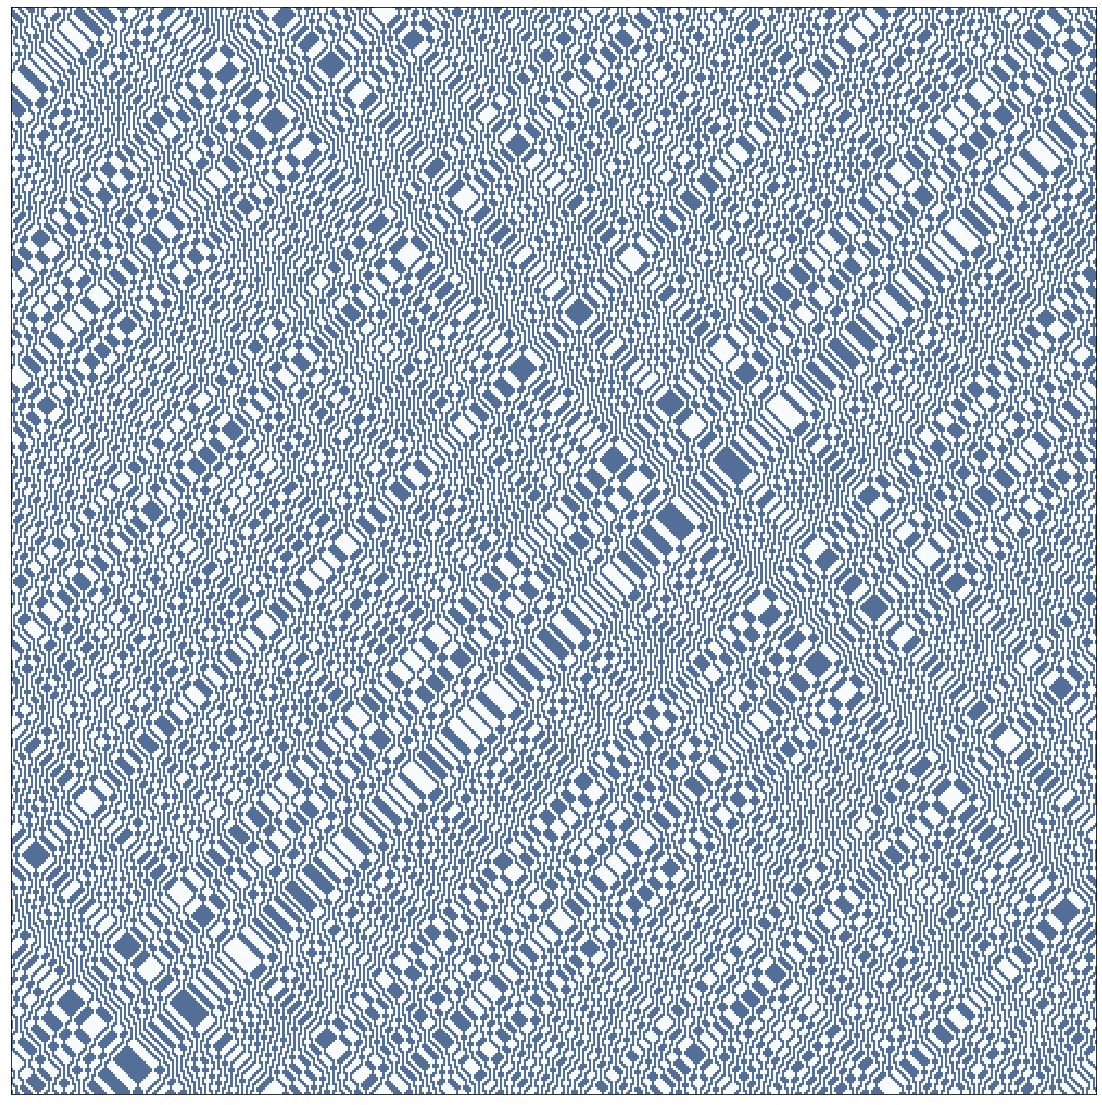

In [3]:
from scipy.ndimage.filters import correlate1d

class Ising(Cell1D):
    def __init__(self, m):
        Cell1D.__init__(self, m)
        
        self.ker = np.array([1,0,1])
        c0 = np.array([True,False]*(m//2+1))
        c0 = c0[0:m]
        c1 = ~c0
        self.c = (c0,c1)
        self.i = 0
    def _step(self):
        H = correlate1d(self.array, self.ker, mode='wrap')
        c = self.c[self.i]
        self.i += 1
        self.i %= 2
        sites = (H==0) & c
        self.array[sites] *= -1

ising = Ising(500)
ising.start_random()
ising.loop(500)
ising.draw()
plt.savefig('p50n500m500.png')

It's pretty cool to look at with a random initial condition, but it does not do anything interesting from a single cell start:

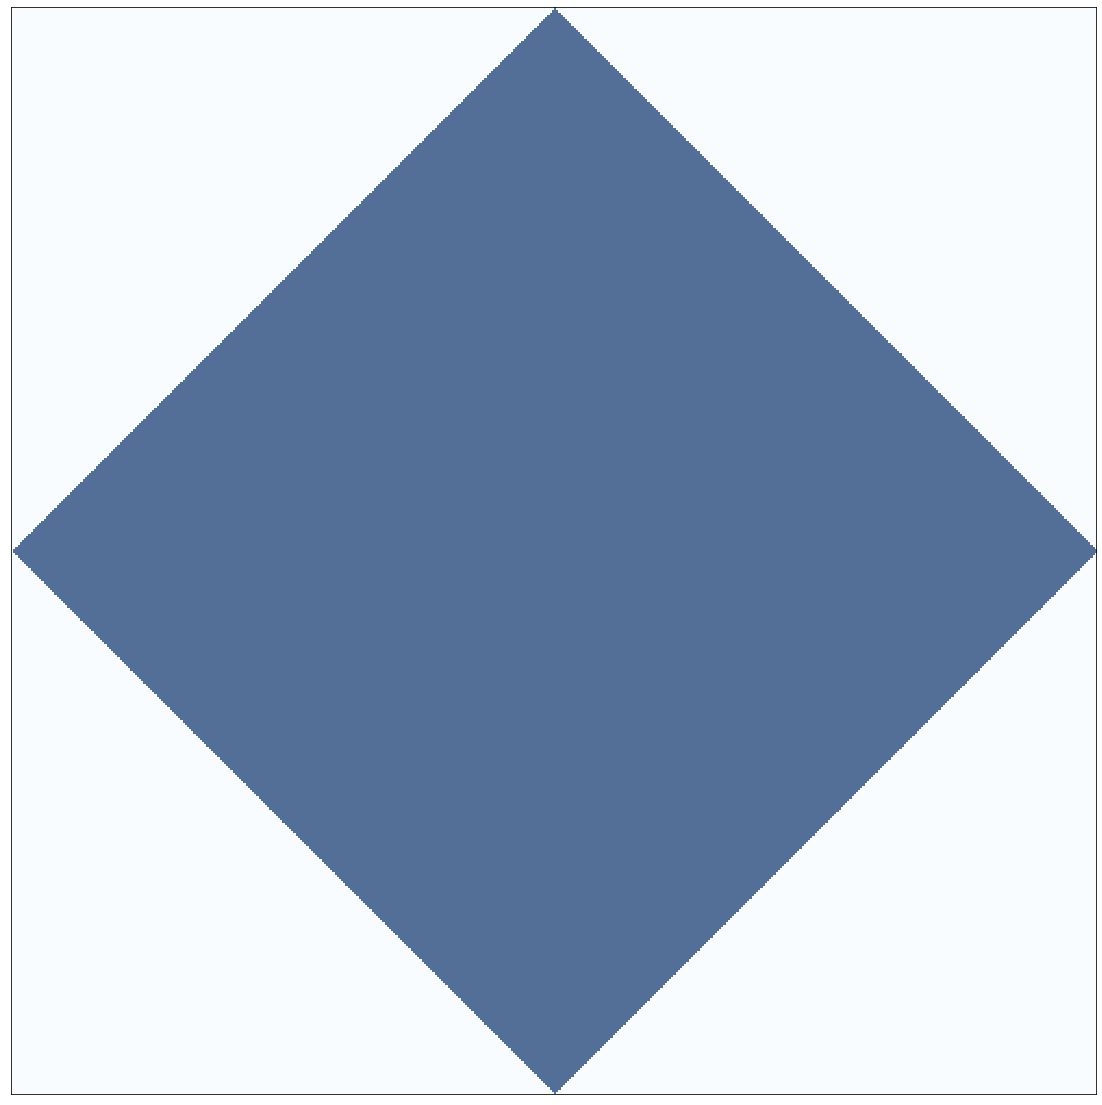

In [3]:
ising = Ising(500)
ising.start_single()
ising.loop(500)
ising.draw()

The result of the paper is that when started with a low entropy bernouli process (Independent identically distributed spins with higher probability of 1 than -1) the system will approach equilibrium and end up looking like one with equal probability. However, I have an issue in this model, which is that the circular boundary is causing a strange dependence on the parity of the number of cells. Even numbers cause a repeating pattern, and odd numbers cause a dieoff.

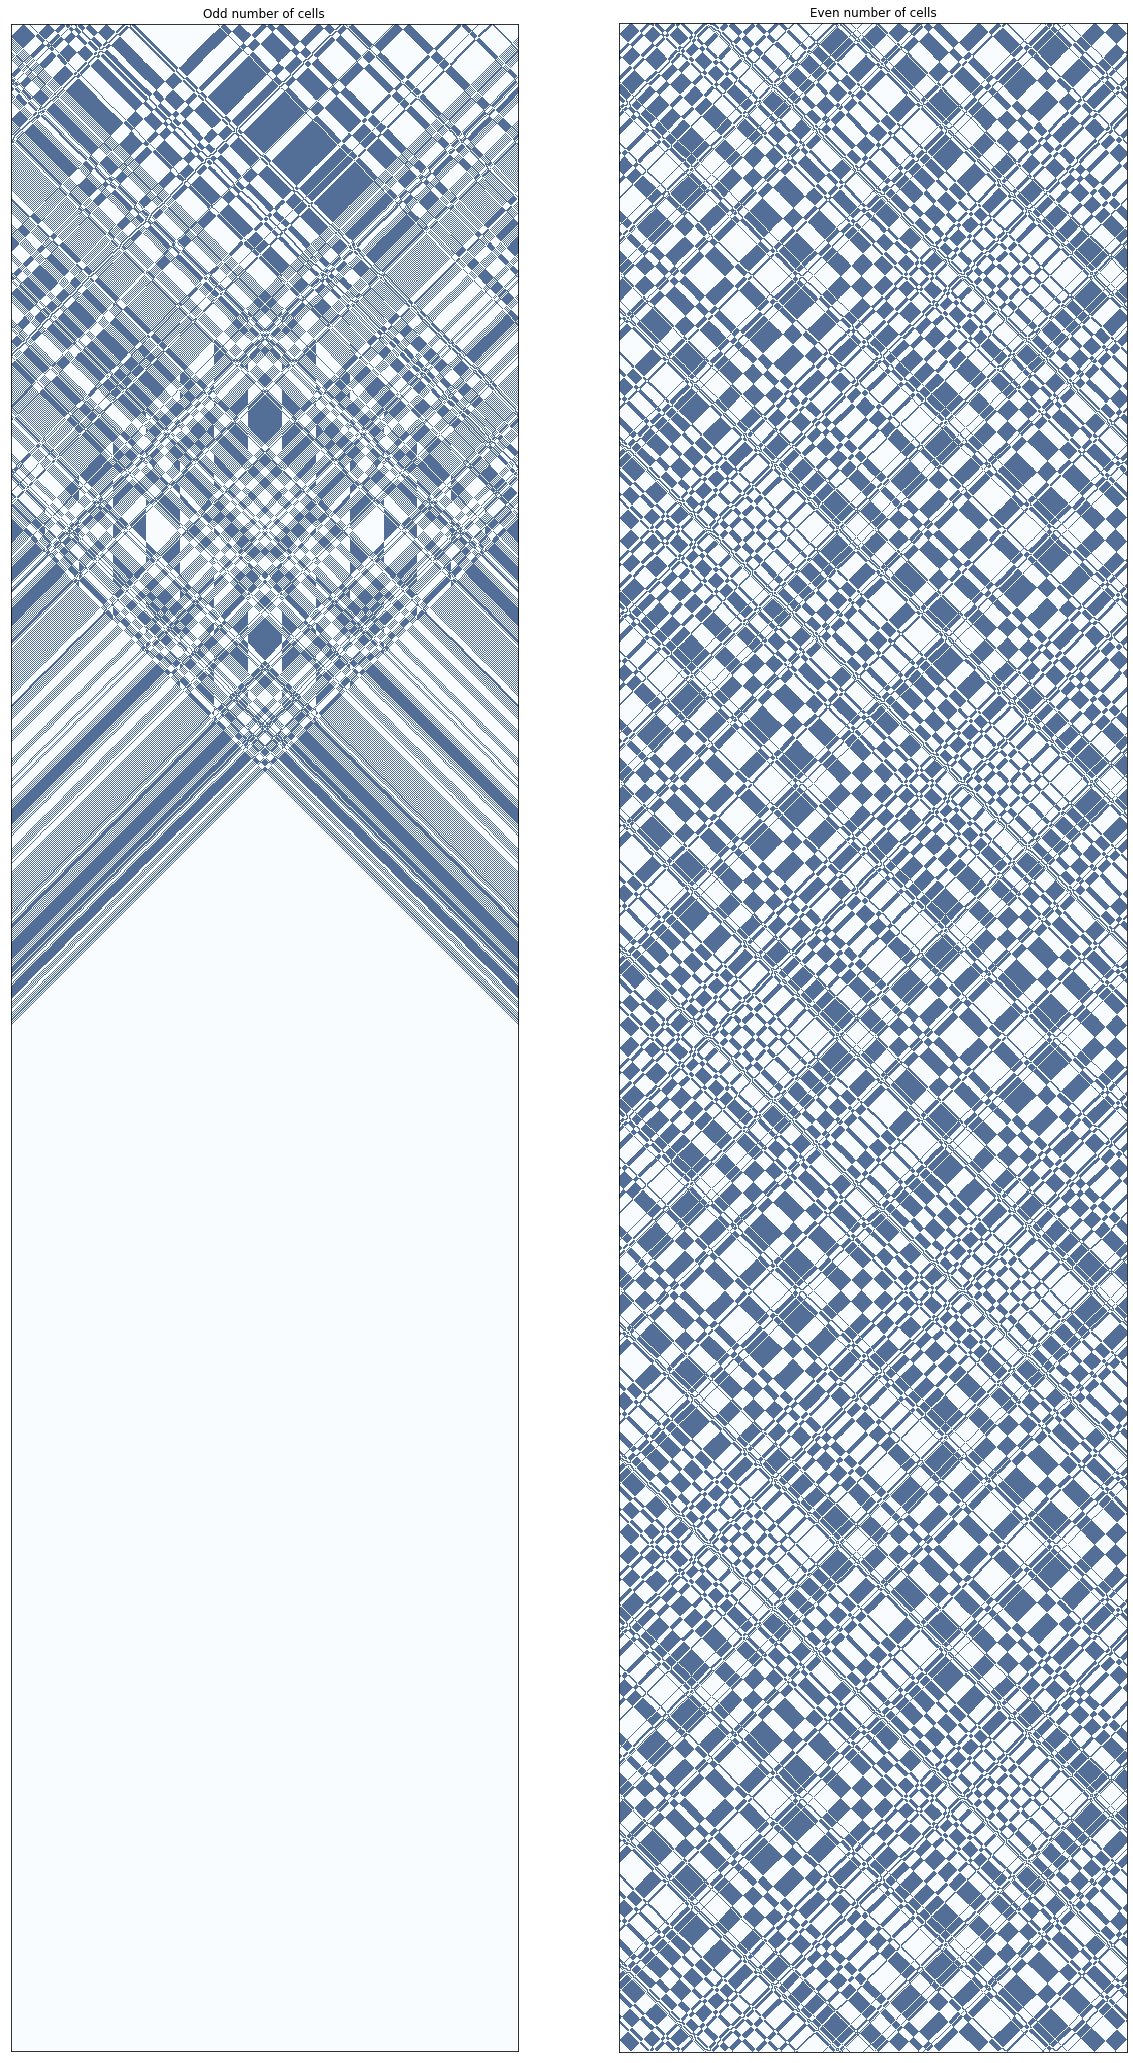

In [4]:
ising_odd = Ising(1001)
ising_odd.start_random(0.05)
ising_odd.loop(4000)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,40))

ising_odd.draw(ax1)
ax1.set_title('Odd number of cells')

ising_even = Ising(1000)
ising_even.start_random(0.05)
ising_even.loop(4000)

ising_even.draw(ax2)
ax2.set_title('Even number of cells');
plt.savefig('evenOdd')

Neither of these are good. With the finite-time dieoff there may not be enough time to reach equilibirum before the boundary effects dominate, and with the repeating pattern there can never be equilibrium. To deal with this, we will have to somehow simulate the rest of the infinite line. I'll try to pick values for the boundary that mimic the distribuation of cells in the simulated section. After doing this we will know about how long we must wait for thermalization, and then we can use a much larger input and ignore the invalid regions.

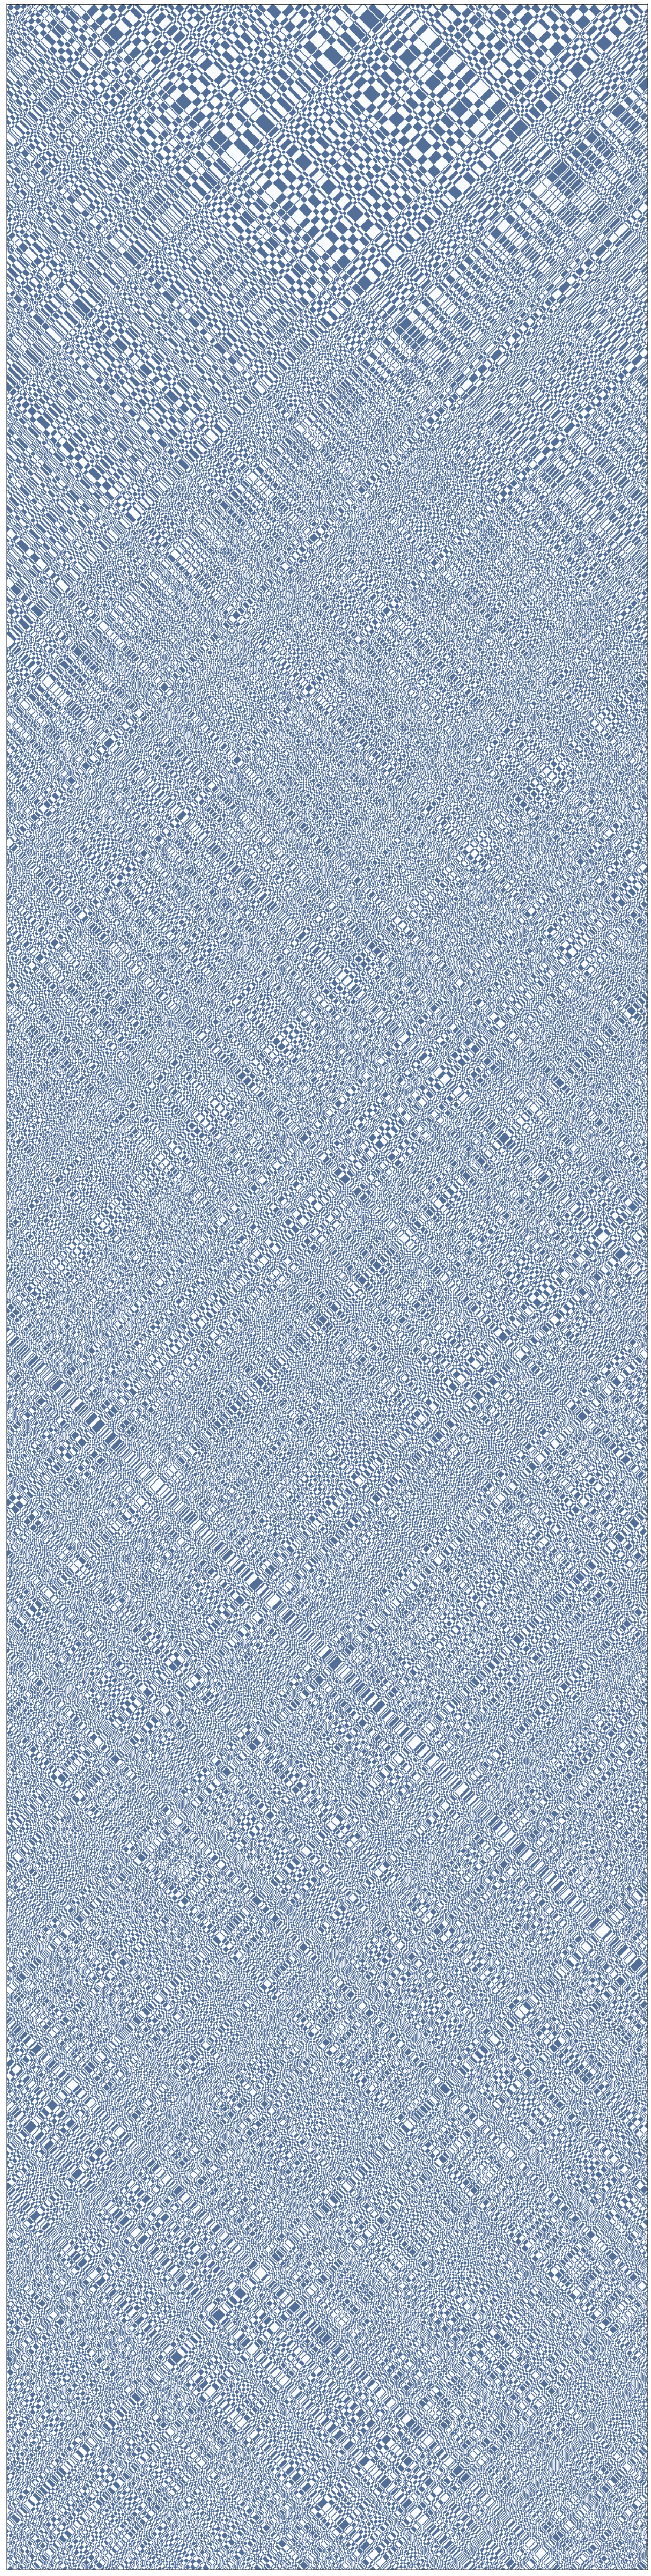

In [5]:
class Ising_Rand(Cell1D):
    def __init__(self, m):
        Cell1D.__init__(self, m)
        
        self.ker = np.array([1,0,1])
        c0 = np.array([True,False]*(m//2+1))
        c0 = c0[0:m]
        c1 = ~c0
        self.c = (c0,c1)
        self.i = 0
    def _step(self):
        a = np.pad(self.array, 1, mode='constant')
        #pick a random value from the simulated section for the unsimulated boundary
        a[[0,-1]] = np.random.choice(self.array, 2)
        H = np.correlate(a, self.ker, mode='valid')
        c = self.c[self.i]
        self.i += 1
        self.i %= 2
        sites = (H==0) & c
        self.array[sites] *= -1
        
ising = Ising_Rand(1000)
ising.start_random(0.1)
ising.loop(4000)
ising.draw(size=(40,80))
plt.savefig('randBoundary.png')

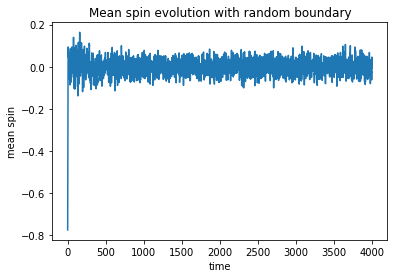

In [9]:
mu = np.mean(ising.image, axis = 1)
plt.plot(mu)
plt.xlabel('time')
plt.ylabel('mean spin')
plt.title('Mean spin evolution with random boundary')
plt.savefig('randBoundaryMeanPlot.png')

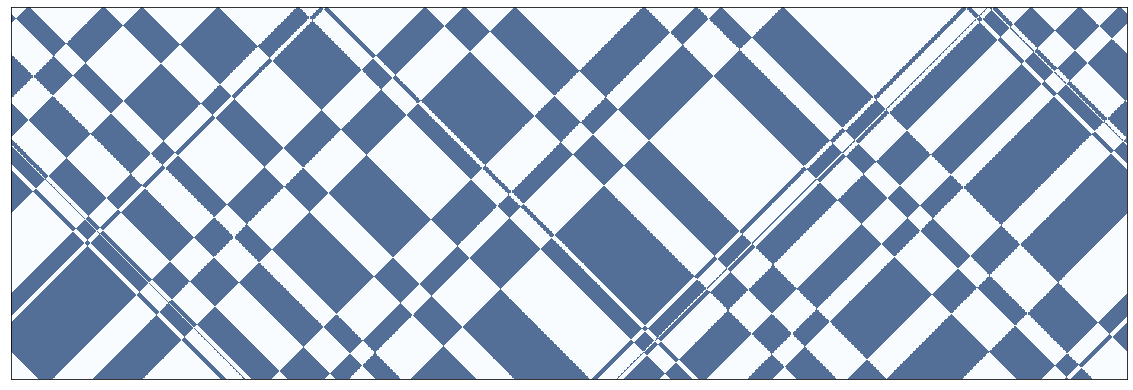

In [36]:
m = 1000
n = 1000

ising = Ising(m+2*n)
ising.start_random(0.01)
ising.loop(n)
ising.draw()

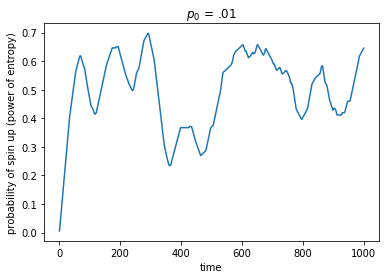

In [37]:
out = np.array(ising.image)
(n,m) = out.shape
valid = out[:,n+1:m-n-1]
valid = (valid + 1)/2
mu = np.mean(valid, axis = 1)
plt.plot(mu)
plt.xlabel('time')
plt.ylabel('probability of spin up (power of entropy)')
plt.title('$p_0$ = .01')
plt.savefig('p_0=.01.png')

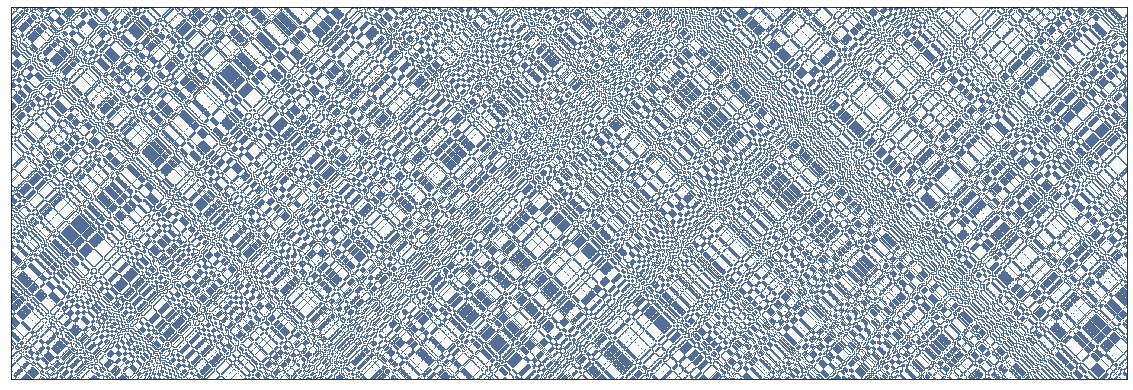

In [38]:
m = 1000
n = 1000

ising = Ising(m+2*n)
ising.start_random(0.1)
ising.loop(n)
ising.draw()

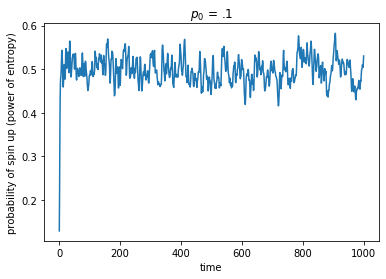

In [39]:
out = np.array(ising.image)
(n,m) = out.shape
valid = out[:,n+1:m-n-1]
valid = (valid + 1)/2
mu = np.mean(valid, axis = 1)
plt.plot(mu)
plt.xlabel('time')
plt.ylabel('probability of spin up (power of entropy)')
plt.title('$p_0$ = .1')
plt.savefig('p_0=.1.png')

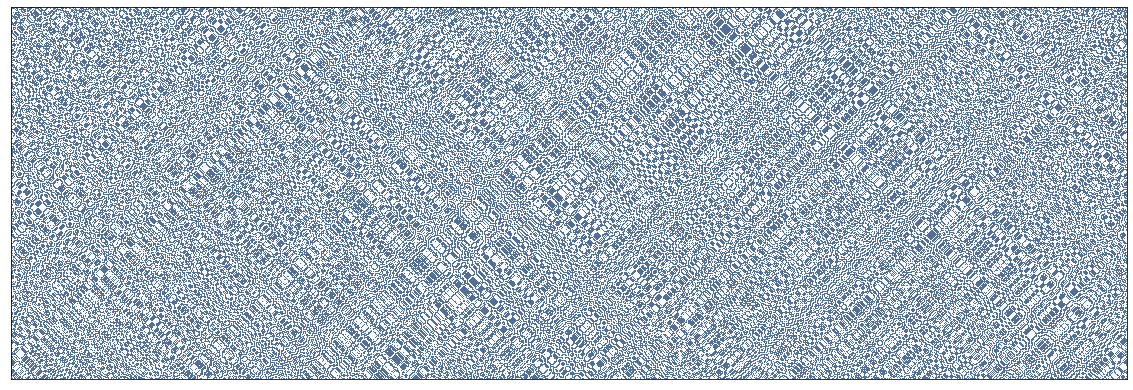

In [40]:
m = 1000
n = 1000

ising = Ising(m+2*n)
ising.start_random(0.2)
ising.loop(n)
ising.draw()

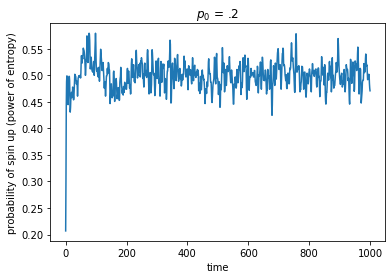

In [41]:
out = np.array(ising.image)
(n,m) = out.shape
valid = out[:,n+1:m-n-1]
valid = (valid + 1)/2
mu = np.mean(valid, axis = 1)
plt.plot(mu)
plt.xlabel('time')
plt.ylabel('probability of spin up (power of entropy)')
plt.title('$p_0$ = .2')
plt.savefig('p_0=.2.png')

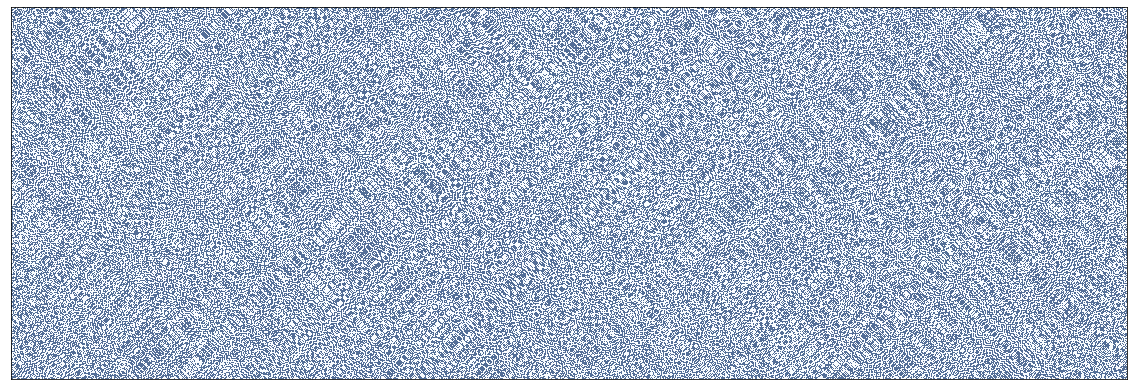

In [42]:
m = 1000
n = 1000

ising = Ising(m+2*n)
ising.start_random(0.4)
ising.loop(n)
ising.draw()

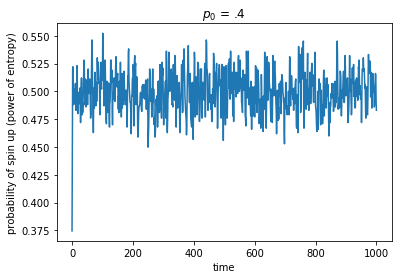

In [44]:
out = np.array(ising.image)
(n,m) = out.shape
valid = out[:,n+1:m-n-1]
valid = (valid + 1)/2
mu = np.mean(valid, axis = 1)
plt.plot(mu)
plt.xlabel('time')
plt.ylabel('probability of spin up (power of entropy)')
plt.title('$p_0$ = .4')
plt.savefig('p_0=.4.png')

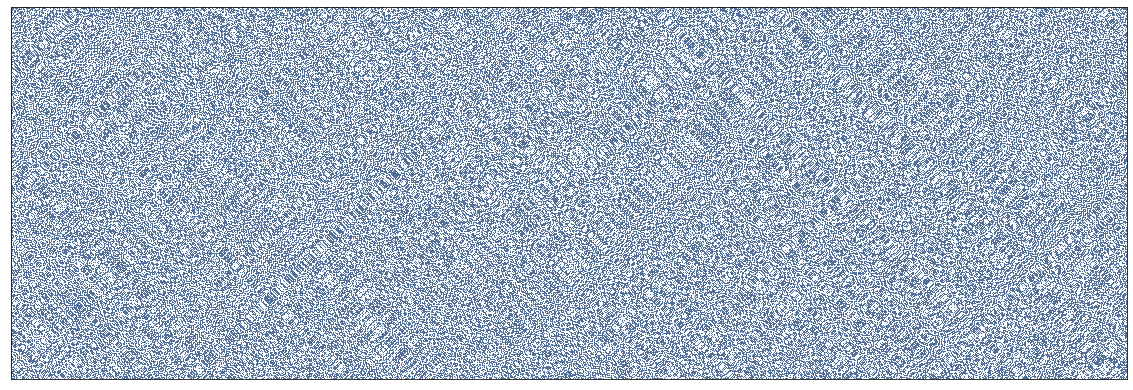

In [45]:
m = 1000
n = 1000

ising = Ising(m+2*n)
ising.start_random(0.5)
ising.loop(n)
ising.draw()

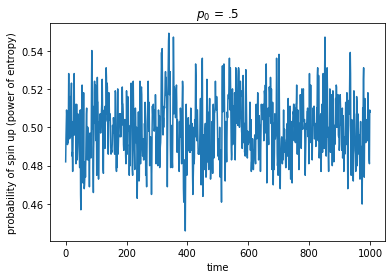

In [46]:
out = np.array(ising.image)
(n,m) = out.shape
valid = out[:,n+1:m-n-1]
valid = (valid + 1)/2
mu = np.mean(valid, axis = 1)
plt.plot(mu)
plt.xlabel('time')
plt.ylabel('probability of spin up (power of entropy)')
plt.title('$p_0$ = .5')
plt.savefig('p_0=.5.png')

The different initial distributions do sort of converge, but it is clear that they do not all thermalize in the same way. The very high initial entropy (p=.01) makes a distinctive slow orbit and varies wildly around 0.5. The lower initial entropies stay closer to 0.5 and jump around faster. This is *not* consistent with reality, where any low entropy state converges to the same equilibrium distribution instead of just converging to the same mean.

It's also clear from looking at the actual plots that the low entropy system really does not even look thermalized. It continues to have big giant highly magnetized domains.

In [23]:
from math import log10

ps = np.logspace(log10(0.001),log10(0.5),20)
mus = []
sigmas = []
m = 3000
n = 3000

for p in ps:
    ising = Ising(m+2*n)
    ising.start_random(p)
    ising.loop(n-1)
    out = np.array(ising.image)
    #get the valid part of the domain (not affected by the edges)
    valid = out[:,n+1:-n-1]
    #-1->0, 1->1
    valid = (valid + 1)/2
    #mean at each time
    mu = np.mean(valid, axis = 1)
    #get only the means after the transient behavior is past
    mu = mu[500:]
    mus.append(np.mean(mu))
    sigmas.append(np.std(mu))

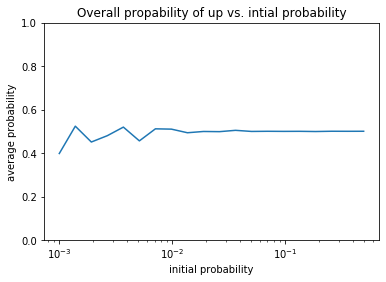

In [32]:
plt.plot(ps,mus)
plt.ylim((0,1))
plt.xscale('log')
plt.xlabel('initial probability')
plt.ylabel('average probability')
plt.title('Overall propability of up vs. intial probability')
plt.savefig('outMu.png')

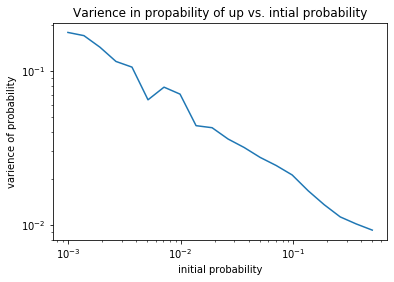

In [33]:
plt.plot(ps,sigmas)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('initial probability')
plt.ylabel('varience of probability')
plt.title('Varience in propability of up vs. intial probability')
plt.savefig('outSigma.png')